1) Imports & Config

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load CSV
df = pd.read_csv("historical_data (1).csv")

# Check column names
print("Columns:", df.columns)

# Use the timestamp column instead of "Date"
if 'Timestamp IST' in df.columns:
    df['Date'] = pd.to_datetime(df['Timestamp IST'], errors='coerce')
elif 'Timestamp' in df.columns:
    df['Date'] = pd.to_datetime(df['Timestamp'], errors='coerce')
else:
    raise ValueError("No timestamp column found in CSV")

df = df.sort_values('Date').reset_index(drop=True)

# Standardize Close/Price column
if 'Close' in df.columns:
    df = df[['Date', 'Close']]
elif 'Adj Close' in df.columns:
    df = df[['Date', 'Adj Close']].rename(columns={'Adj Close': 'Close'})
elif 'Price' in df.columns:
    df = df[['Date', 'Price']].rename(columns={'Price': 'Close'})
elif 'Size USD' in df.columns:  # <-- looks like your file has trade prices here
    df = df[['Date', 'Size USD']].rename(columns={'Size USD': 'Close'})
else:
    raise ValueError("Could not find a Close/Adj Close/Price/Size USD column in your CSV")

# Compute daily returns
df['Return'] = df['Close'].pct_change()

print(df.head())


Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
                 Date    Close    Return
0 2023-01-05 01:06:00   156.39       NaN
1 2023-01-05 01:06:00   137.08 -0.123473
2 2023-01-05 01:06:00   183.53  0.338853
3 2023-05-12 03:11:00  1100.11  4.994170
4 2023-05-12 03:11:00  1935.95  0.759779


2) Load Local BTC Price Data

In [8]:


# Handle timestamp
if 'Timestamp IST' in px.columns:
    px['Date'] = pd.to_datetime(px['Timestamp IST'], errors='coerce')
elif 'Timestamp' in px.columns:
    px['Date'] = pd.to_datetime(px['Timestamp'], errors='coerce')
else:
    raise ValueError("No valid timestamp column found in CSV")

# Try to detect price column
price_cols = [c for c in px.columns if c.lower() in ['close', 'adj close', 'price', 'size usd']]
if not price_cols:
    # fallback: pick the *first numeric column* that isn’t Date/IDs
    num_cols = [c for c in px.columns if pd.api.types.is_numeric_dtype(px[c])]
    if not num_cols:
        raise ValueError("Could not find a numeric price column in the CSV")
    close_col = num_cols[0]  # choose first numeric column
else:
    close_col = price_cols[0]

# Standardize
px = px[['Date', close_col]].rename(columns={close_col: 'Close'})
px = px.dropna().sort_values('Date').reset_index(drop=True)

# Daily returns
px['Ret'] = px['Close'].pct_change()

print(px.head())


                 Date    Close       Ret
0 2023-01-05 01:06:00   156.39       NaN
1 2023-01-05 01:06:00   137.08 -0.123473
2 2023-01-05 01:06:00   183.53  0.338853
3 2023-05-12 03:11:00  1100.11  4.994170
4 2023-05-12 03:11:00  1935.95  0.759779


3) Create “Sentiment Proxies” from Price



In [9]:
# 30-day volatility as fear proxy
px['Volatility'] = px['Ret'].rolling(30).std()

# 30-day momentum as greed proxy
px['Momentum'] = px['Close'] / px['Close'].shift(30) - 1

# Z-score of daily returns
px['Zscore'] = (px['Ret'] - px['Ret'].rolling(30).mean()) / px['Ret'].rolling(30).std()


4) Trading Strategies

In [10]:
# Strategy A: Follower (go long if momentum > 0)
px['A_pos'] = (px['Momentum'] > 0).astype(int)

# Strategy B: Contrarian (go long if volatility is high -> expecting rebound)
px['B_pos'] = (px['Volatility'] > px['Volatility'].rolling(60).mean()).astype(int)

# Strategy C: Extreme fear (long if Z-score < -1)
px['C_pos'] = (px['Zscore'] < -1).astype(int)

# Buy & Hold benchmark
px['BH_ret'] = px['Ret']

# Apply returns with transaction costs
perf = px[['Date','Ret','BH_ret','A_pos','B_pos','C_pos']].dropna()
for col in ['A_pos','B_pos','C_pos']:
    perf[f'{col}_ret_gross'] = perf[col].shift(1) * perf['Ret']
    turnover = (perf[col].shift(1).fillna(0) - perf[col]).abs()
    tc = (TX_COST_BPS / 10000.0) * turnover
    perf[f'{col}_ret_net'] = perf[f'{col}_ret_gross'] - tc

perf['BH_ret_net'] = perf['BH_ret']


5) Performance Metrics

In [12]:
def perf_stats(returns, freq=365, name='strategy'):
    r = pd.to_numeric(returns, errors='coerce').dropna()   # <--- ensure numeric
    if len(r) == 0:
        return {'name': name, 'CAGR': np.nan, 'Vol': np.nan,
                'Sharpe': np.nan, 'MaxDD': np.nan}

    cum = (1 + r).prod()
    years = (r.index[-1] - r.index[0]).days / 365.25
    cagr = cum**(1/years) - 1 if years > 0 else np.nan

    vol = r.std() * np.sqrt(freq)
    sharpe = (r.mean() * freq - RISK_FREE * freq) / (r.std() * np.sqrt(freq)) if r.std() > 0 else np.nan

    eq = (1 + r).cumprod()
    dd = (eq / eq.cummax() - 1).min()

    return {'name': name, 'CAGR': cagr, 'Vol': vol, 'Sharpe': sharpe, 'MaxDD': dd}


In [15]:

perf = perf.dropna().copy()
perf.index = pd.to_datetime(perf['Date'])

results = [perf_stats(perf['BH_ret_net'], name='Buy&Hold')]
for col in ['A_pos', 'B_pos', 'C_pos']:
    results.append(perf_stats(perf[f'{col}_ret_net'], name=col.replace('_pos','')))

stats_df = pd.DataFrame(results)
print("==== Performance Summary ====")
print(stats_df)


==== Performance Summary ====
       name          CAGR           Vol    Sharpe     MaxDD
0  Buy&Hold -1.000000e+00  69629.590290  0.387877 -1.000000
1         A -1.000000e+00   1318.859571  0.641303 -1.000000
2         B -1.000000e+00  15741.514095  0.526252 -1.000000
3         C  1.076813e+20   9261.375725  0.071750 -0.958013


6) Plots

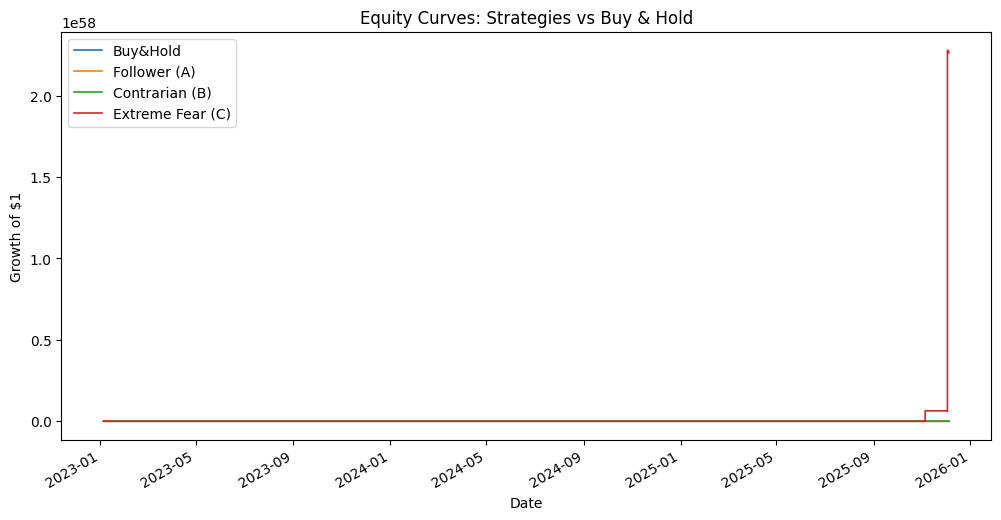

In [19]:
if MAX_PLOTS:
    eq = pd.DataFrame(index=perf.index)
    eq['Buy&Hold'] = (1 + perf['BH_ret_net']).cumprod()
    eq['Follower (A)'] = (1 + perf['A_pos_ret_net']).cumprod()
    eq['Contrarian (B)'] = (1 + perf['B_pos_ret_net']).cumprod()
    eq['Extreme Fear (C)'] = (1 + perf['C_pos_ret_net']).cumprod()

    eq.plot(figsize=(12,6), linewidth=1.2, title="Equity Curves: Strategies vs Buy & Hold")
    plt.ylabel("Growth of $1")
    plt.show()
